# [실습3] 듀얼 인코더 모델 사용

[케라스의 듀얼 인코더 자연어 이미지 탐색](https://keras.io/examples/nlp/nl_image_search/) 내용을 공부하여 정리합니다.

- 이미지와 문장을 인코딩 하는 두 개의 인코더를 사용하는 모델 훈련
- 문장을 이용하여 이미지 탐색. [OpenAI의 Clip](https://openai.com/blog/clip/)과 유사하게 작동.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 기타 설정
import glob
import cv2
import os

In [ ]:
# Fashion-MNIST 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 이미지 전처리
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0  # (28, 28, 1) 형태로 확장
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

# 텍스트 데이터: Fashion-MNIST 클래스 라벨 이름
fashion_mnist_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# 캡션 생성
text_train = [fashion_mnist_classes[int(label)] for label in y_train]
text_val = [fashion_mnist_classes[int(label)] for label in y_val]
text_test = [fashion_mnist_classes[int(label)] for label in y_test]


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def build_image_encoder():
    base_model = keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
    base_model.trainable = False
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.UpSampling2D(size=(8, 8))(inputs)  # (28, 28) -> (224, 224)
    x = layers.Concatenate()([x, x, x])  # 채널을 3으로 복제
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs, outputs, name="image_encoder")

image_encoder = build_image_encoder()


In [ ]:
def build_text_encoder(vocab_size, embedding_dim, max_length):
    inputs = keras.Input(shape=(max_length,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs, outputs, name="text_encoder")

# 텍스트 전처리
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(fashion_mnist_classes)

text_train_seqs = tokenizer.texts_to_sequences(text_train)
text_val_seqs = tokenizer.texts_to_sequences(text_val)
text_test_seqs = tokenizer.texts_to_sequences(text_test)

max_length = max(len(seq) for seq in text_train_seqs)

text_train_padded = keras.preprocessing.sequence.pad_sequences(text_train_seqs, padding="post", maxlen=max_length)
text_val_padded = keras.preprocessing.sequence.pad_sequences(text_val_seqs, padding="post", maxlen=max_length)
text_test_padded = keras.preprocessing.sequence.pad_sequences(text_test_seqs, padding="post", maxlen=max_length)

text_encoder = build_text_encoder(vocab_size=10000, embedding_dim=128, max_length=max_length)


In [ ]:
class ContrastiveModel(keras.Model):
    def __init__(self, image_encoder, text_encoder, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temperature = 0.1

    def compile(self, optimizer, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.optimizer = optimizer
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        image_inputs, text_inputs = inputs
        image_embeddings = self.image_encoder(image_inputs)
        text_embeddings = self.text_encoder(text_inputs)
        return image_embeddings, text_embeddings

    def train_step(self, data):
        (image_inputs, text_inputs), _ = data

        with tf.GradientTape() as tape:
            image_embeddings, text_embeddings = self((image_inputs, text_inputs))
            logits = tf.matmul(image_embeddings, text_embeddings, transpose_b=True)
            labels = tf.range(tf.shape(logits)[0])
            loss = self.loss_fn(labels, logits / self.temperature)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": loss}

contrastive_model = ContrastiveModel(image_encoder, text_encoder)
contrastive_model.compile(optimizer=keras.optimizers.Adam())


In [ ]:
# 훈련 데이터 준비
train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, text_train_padded), y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, text_val_padded), y_val)).batch(32)

# 모델 훈련
history = contrastive_model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1500/1500 [==============================] - 156s 98ms/step - loss: 2.1236 - val_loss: 0.0000e+00
Epoch 2/10
1500/1500 [==============================] - 146s 97ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1500/1500 [==============================] - 145s 97ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1500/1500 [==============================] - 147s 98ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1500/1500 [==============================] - 146s 97ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1500/1500 [==============================] - 142s 94ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1500/1500 [==============================] - 144s 96ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
1500/1500 [==============================] - 144s 96ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
1500/1500 [==============================] - 141s 94ms/step - loss: 0.0000e+00 - val_loss

In [ ]:
# 이미지 검색 함수와 함께 코사인 유사도 계산
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

313/313 [==============================] - 28s 87ms/step


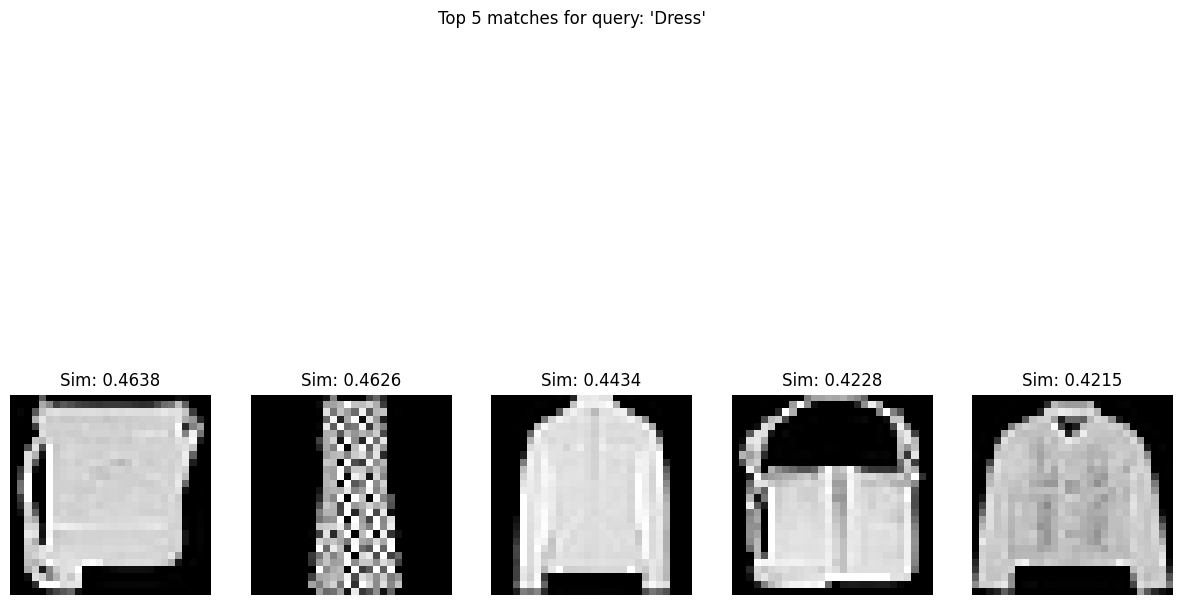

In [ ]:
def find_top_k_images(image_encoder, text_encoder, query_text, k=5):
    text_sequence = tokenizer.texts_to_sequences([query_text])
    text_padded = keras.preprocessing.sequence.pad_sequences(text_sequence, padding="post", maxlen=max_length)

    # 텍스트 임베딩 얻기
    text_embedding = text_encoder.predict(text_padded)

    # 모든 이미지 임베딩 얻기
    image_embeddings = image_encoder.predict(x_test)

    # 코사인 유사도 계산
    similarities = [cosine_similarity(image_embedding, text_embedding[0]) for image_embedding in image_embeddings]

    # 가장 유사한 k개의 이미지 선택
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return x_test[top_k_indices], np.array(similarities)[top_k_indices]

# "Dress" 쿼리 텍스트로 검색
query_text = "Dress"
matched_images, similarities = find_top_k_images(image_encoder, text_encoder, query_text, k=5)

# 이미지와 코사인 유사도 출력
plt.figure(figsize=(15, 10))
for i in range(len(matched_images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(matched_images[i]), cmap="gray")
    plt.title(f"Sim: {similarities[i]:.4f}")
    plt.axis("off")

plt.suptitle(f"Top 5 matches for query: '{query_text}'")
plt.show()
